In [1]:
# Project 3: Real-time Stock Prediction Pipeline 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# PHASE 1: DATA ENGINEERING

ticker_symbol = "AAPL"

print(f"Fetching real-time data for {ticker_symbol}...")
# Fetch data
df = yf.download(ticker_symbol, start="2020-01-01", progress=False)

# CRITICAL FIX FOR YFINANCE UPDATE
# If data comes with MultiIndex columns (Price, Ticker), flatten it
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Ensure data is sorted
df = df.sort_index()



Fetching real-time data for AAPL...


In [2]:
# PHASE 2: DATA TRANSFORMATION

# Create features
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Daily_Return'] = df['Close'].pct_change()
df['Prev_Close'] = df['Close'].shift(1)

# Drop NaN values created by rolling/shifting
df = df.dropna()



In [3]:
# PHASE 3: MACHINE LEARNING

features = ['Open', 'High', 'Low', 'Volume', 'MA50', 'Prev_Close']
target = 'Close'

X = df[features]
y = df[target]

# .squeeze() converts a single-column DataFrame into a Series (1D array)
if y.ndim > 1:
    y = y.squeeze()

# Split data (80% train, 20% test) without shuffling (time-series)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Evaluate
# Both y_test and predictions should now be 1D arrays
mae = mean_absolute_error(y_test, predictions)
print(f"Model Mean Absolute Error: ${mae:.2f}")



Model Mean Absolute Error: $11.04


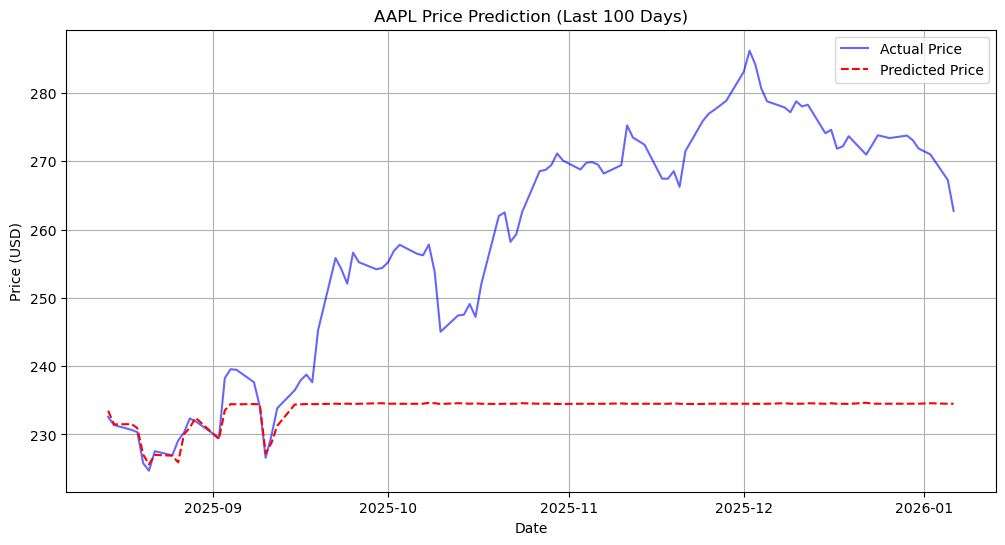


Feature Importance:
Open: 0.0240
High: 0.6914
Low: 0.2482
Volume: 0.0001
MA50: 0.0116
Prev_Close: 0.0246


In [4]:
# PHASE 4: DATA ANALYTICS & VISUALIZATION

# Create DataFrame for plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(results['Actual'].tail(100), label='Actual Price', color='blue', alpha=0.6)
plt.plot(results['Predicted'].tail(100), label='Predicted Price', color='red', linestyle='--')
plt.title(f'{ticker_symbol} Price Prediction (Last 100 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
print("\nFeature Importance:")
for feature, imp in zip(features, model.feature_importances_):
    print(f"{feature}: {imp:.4f}")

This visualization compares **Actual prices (Blue) vs. Predicted prices (Red).**

**+ Visual Analysis:** The model follows the trend briefly but then the red line flatlines while the actual price skyrockets. 

=> This indicates the model (likely Random Forest) cannot extrapolate trends it hasn't seen before.

**+ Key Insight:** The Daily High price was the most relied-upon feature (68%) for making predictions.